<a href="https://colab.research.google.com/github/nhtlongcs/VinBigData-Abnormalities-Detection/blob/ffyytt-fasterrcnn/2021_VIN_FRCNN_TRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Jan 31 22:24:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install kaggle
!cp '/content/gdrive/My Drive/Kaggle/kaggle.json' 'kaggle.json'
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!cp "gdrive/MyDrive/2021_VINBIGDATA/train.csv" "data/vinbigdata/train.csv"

cp: cannot create regular file 'data/vinbigdata/train.csv': No such file or directory


In [5]:
!pip install -qq ensemble_boxes
!pip install -qq pydicom
!pip install -qq git+https://github.com/albumentations-team/albumentations

     |████████████████████████████████| 1.9MB 12.7MB/s 
     |████████████████████████████████| 952kB 12.9MB/s 


In [6]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
import pydicom
import random
import zipfile
from PIL import Image
from tqdm import *
from datetime import datetime
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from matplotlib import pyplot as plt
from ensemble_boxes import *
import multiprocessing

import warnings
warnings.filterwarnings("ignore")

In [7]:
iou_thr = 0.4
skip_box_thr = 0.1

class TrainGlobalConfig:
    num_workers = multiprocessing.cpu_count()
    batch_size = 8
    n_epochs = 32
    lr = 0.0001
    folder = 'gdrive/MyDrive/2021_VINBIGDATA/FRCNN/COLAB_FOLD0'
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [8]:
if not os.path.exists('data/vinbigdata/'):
    os.makedirs('data/vinbigdata/')
    !cp "gdrive/MyDrive/2021_VINBIGDATA/train.csv" "data/vinbigdata/train.csv"

In [9]:
SEED = 1312
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [10]:
N_CLASSES = 14
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
df = pd.read_csv('data/vinbigdata/train.csv')
df.loc[df["class_id"] == 14, ['x_max', 'y_max']] = 1.0
df.loc[df["class_id"] == 14, ['x_min', 'y_min']] = 0.0
df["class_id"] = df["class_id"] + 1
df.loc[df["class_id"] == 15, ["class_id"]] = 0
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,fold
0,50a418190bc3fb1ef1633bf9678929b3,No finding,0,R11,0.0,0.0,1.0,1.0,2332,2580,3
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,0,R7,0.0,0.0,1.0,1.0,2954,3159,2
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,2080,2336,2
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,1,R10,1264.0,743.0,1611.0,1019.0,2304,2880,0
4,063319de25ce7edb9b1c6b8881290140,No finding,0,R10,0.0,0.0,1.0,1.0,2540,3072,1


In [11]:
image_ids = df['image_id'].unique()
train_ids = df['image_id'][df['fold'] != 0].unique()
valid_ids = df['image_id'][df['fold'] == 0].unique()
print(len(train_ids), len(valid_ids))
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]

12001 2999


In [12]:
if not os.path.exists('data/vinbigdata/train/'):
    os.makedirs('data/vinbigdata/train/')
    with zipfile.ZipFile('/content/gdrive/MyDrive/2021_VINBIGDATA/vinbigdata-original-image-dataset.zip') as z:
        for filename in tqdm(image_ids):
            with open('data/vinbigdata/train/'+filename+'.jpg', 'wb+') as f:
                f.write(z.read('vinbigdata/train/'+filename+'.jpg'))

100%|██████████| 15000/15000 [16:22<00:00, 15.26it/s]


In [13]:
def get_train_transforms():
    return A.Compose(
        [
         A.ToGray(p=0.1),
         A.OneOf([
            A.MotionBlur(p=0.2),
            A.GaussianBlur(),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
         
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.3),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                 val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, 
                                       p=0.3),            
        ], p=0.5),

         A.HorizontalFlip(p=0.5),
         A.VerticalFlip(p=0.25),
         A.RandomRotate90(p=0.25),
         
         #A.Resize(height=imgSize, width=imgSize, p=1.0),
         ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
         #A.Resize(height=imgSize, width=imgSize, p=1.0),
         ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [14]:
def run_wbf(boxes, labels, w, h, wn, hn, iou_thr):
    scores = [np.array([0.9]*len(boxes))]
    
    boxes[:, 0] = (boxes[:, 0] / w)
    boxes[:, 1] = (boxes[:, 1] / h)
    boxes[:, 2] = (boxes[:, 2] / w)
    boxes[:, 3] = (boxes[:, 3] / h)
    boxes = [boxes]
    
    labels = [labels]
    
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr,
                                                  skip_box_thr=0.001)
    boxes[:, 0] = (boxes[:, 0] * wn)
    boxes[:, 1] = (boxes[:, 1] * hn)
    boxes[:, 2] = (boxes[:, 2] * wn)
    boxes[:, 3] = (boxes[:, 3] * hn)
    return boxes, labels

In [15]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_dir, transforms=None, test=False):
        super().__init__()

        self.image_ids = marking["image_id"].unique()
        self.image_dir = image_dir
        self.marking = marking
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        return image, target, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        try:
            image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR).copy().astype(np.float32)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0

            w,h = image.shape[1], image.shape[0]
            
            records = self.marking[self.marking['image_id'] == image_id]
            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            labels = records['class_id'].values
            boxes, labels = run_wbf(boxes, labels, w, h, w, h, iou_thr)

            self.image = image
            self.boxes = boxes
            self.labels = labels

            return image, boxes, labels
        except:
            return self.image, self.boxes, self.labels
        

In [16]:
image_paths = 'data/vinbigdata/train'
train_dataset = DatasetRetriever(
    marking=train_df,
    image_dir=image_paths,
    transforms=get_train_transforms(),
    test = False
)

validation_dataset = DatasetRetriever(
    marking=valid_df,
    image_dir=image_paths,
    transforms=get_valid_transforms(),
    test = True
)

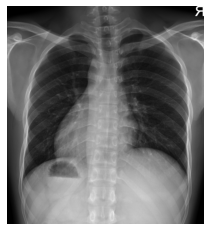

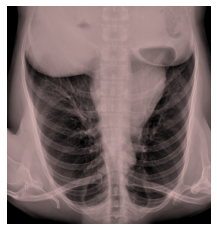

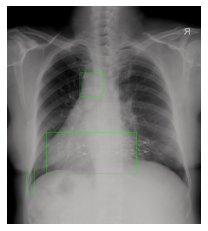

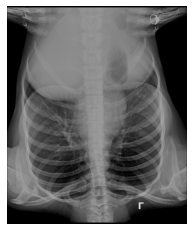

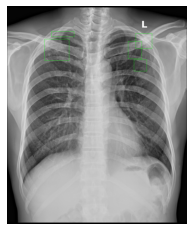

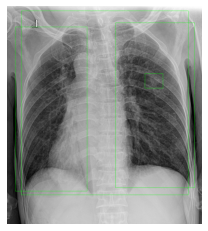

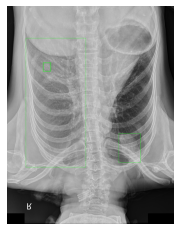

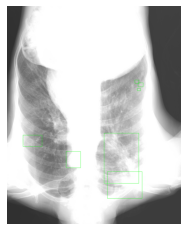

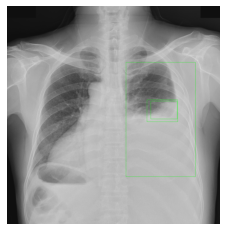

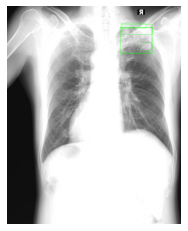

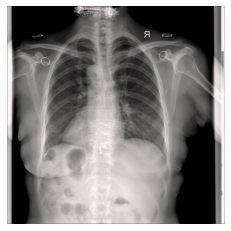

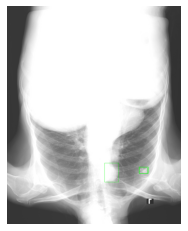

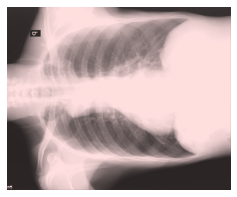

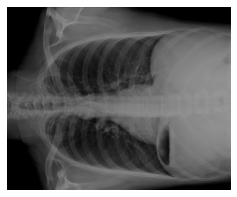

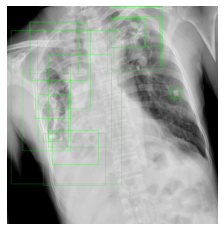

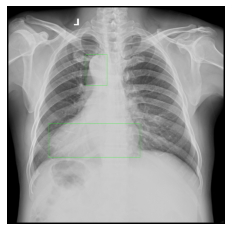

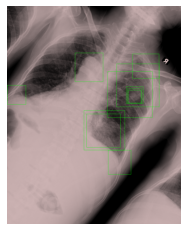

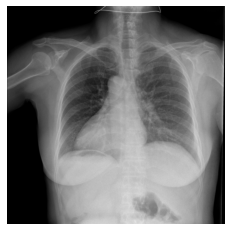

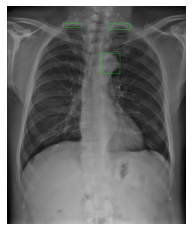

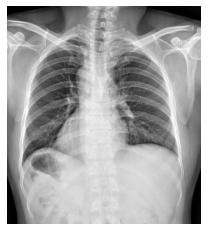

In [17]:
for i in range(20):
    image, target, image_id = train_dataset[i]
    boxes = target['boxes'].cpu().numpy().astype(np.int64)

    numpy_image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    for box in boxes:
        cv2.rectangle(numpy_image, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 2)

    ax.set_axis_off()
    ax.imshow(numpy_image)
    plt.show()

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        self.bug = {}

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        #self.best_mAP04 = -1

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.model.eval()
            self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch{round(summary_loss.avg*1000)}.bin')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    #mAP04 = self.metric_fn.value(iou_thresholds=0.5)['mAP']
                    print(
                        '\r'+f'Val Step {step}/{len(val_loader)}, ' + \
                        #f'mAP@0.4: {mAP04:.5f}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end=''
                    )
            with torch.no_grad():
                images = list(image.to(device) for image in images)
                batch_size = len(images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = self.model(images, targets)
                loss = sum(loss for loss in loss_dict.values())

                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        '\r'+f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end=''
                    )
            
            images = list(image.to(device) for image in images)
            batch_size = len(images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(images, targets)

            loss = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            loss.backward()
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()
            

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print('\n'+message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [20]:
net = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 15
in_features = net.roi_heads.box_predictor.cls_score.in_features
net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net.to(device)
params = [p for p in net.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [ ]:
run_training()


Fitter prepared. Device is cuda


2021-01-31T22:42:37.198350
LR: 0.0001
Train Step 1499/1500, summary_loss: 0.41573, time: 2723.84235
[RESULT]: Train. Epoch: 0, summary_loss: 0.41558, time: 2725.27173
Val Step 374/375, summary_loss: 0.22007, time: 310.55954
[RESULT]: Val. Epoch: 0, summary_loss: 0.21977, time: 311.35018


2021-01-31T23:33:23.102034
LR: 0.0001
Train Step 1499/1500, summary_loss: 0.36322, time: 2718.69513
[RESULT]: Train. Epoch: 1, summary_loss: 0.36306, time: 2720.04609
Val Step 374/375, summary_loss: 0.22709, time: 308.15832
[RESULT]: Val. Epoch: 1, summary_loss: 0.22680, time: 308.96074


2021-02-01T00:23:57.858538
LR: 0.0001
Train Step 1499/1500, summary_loss: 0.34816, time: 2703.22694
[RESULT]: Train. Epoch: 2, summary_loss: 0.34804, time: 2704.84161
Val Step 374/375, summary_loss: 0.21723, time: 309.56113
[RESULT]: Val. Epoch: 2, summary_loss: 0.21692, time: 310.37915


2021-02-01T01:14:18.068075
LR: 0.0001
Train Step 1499/1500, summary_loss: 0.33356, time: 2727.1